In [1]:
# Planned Terminal Schedule from GTFS Static Data
# Creates schedule_matrix_4terminal_planned.npy
#
# This aligns with the paper's intent: terminal input = dispatcher's PLAN
# rather than observed arrivals.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# =============================================================================
# CONSTANTS
# =============================================================================

# GTFS Static Files
STOP_TIMES_FILE = "../data/static/stop_times.txt"
TRIPS_FILE = "../data/static/trips.txt"
CALENDAR_FILE = "../data/static/calendar.txt"

# Reference files (to match time index)
HEADWAY_MATRIX_FILE = "../data/headway_matrix_topology.npy"
ARRIVALS_FILE = "../data/nyc_subway_a_line_arrivals_2025.csv"

# Output
OUTPUT_FILE = "../data/schedule_matrix_4terminal_planned.npy"

# Terminal Stop IDs (departures from these stations)
# Channel 0: Inwood-207 St (Northbound origin)
# Channel 1: Lefferts Blvd (Southbound Lefferts branch)
# Channel 2: Far Rockaway (Southbound Rockaway branch)
# Channel 3: Rockaway Park (Southbound Rockaway Park shuttle)
TERMINAL_STOPS = {
    0: 'A02',   # Inwood-207 St (trains depart southbound)
    1: 'A65',   # Lefferts Blvd (trains depart northbound)
    2: 'H11',   # Far Rockaway (trains depart northbound)
    3: 'H15',   # Rockaway Park (trains depart northbound)
}

# Direction of departures at each terminal
# Inwood: trains DEPART southbound (direction_id=1)
# Others: trains DEPART northbound (direction_id=0)
TERMINAL_DEPART_DIR = {
    0: 'S',  # Inwood → Southbound departures
    1: 'N',  # Lefferts → Northbound departures  
    2: 'N',  # Far Rockaway → Northbound departures
    3: 'N',  # Rockaway Park → Northbound departures
}

TIME_BIN_SIZE_MIN = 1

print("Planned Terminal Schedule Generator")
print("="*60)

Planned Terminal Schedule Generator


In [2]:
# 1. Load GTFS Static Data

stop_times = pd.read_csv(STOP_TIMES_FILE)
trips = pd.read_csv(TRIPS_FILE)
calendar = pd.read_csv(CALENDAR_FILE)

print(f"Stop times: {len(stop_times):,} records")
print(f"Trips: {len(trips):,} records")
print(f"Calendar: {len(calendar)} service patterns")

# Filter to A-line trips only
a_trips = trips[trips['route_id'] == 'A'].copy()
print(f"\nA-line trips: {len(a_trips):,}")

# Join stop_times with trips to get route info
a_stop_times = stop_times[stop_times['trip_id'].isin(a_trips['trip_id'])].copy()
print(f"A-line stop times: {len(a_stop_times):,}")

Stop times: 562,597 records
Trips: 20,304 records
Calendar: 3 service patterns

A-line trips: 940
A-line stop times: 32,257


In [3]:
# 2. Extract Terminal Departures

def get_terminal_departures(stop_times_df, trips_df, terminal_stop, depart_dir):
    """
    Get scheduled departures from a terminal station.
    
    Args:
        terminal_stop: Base stop ID (e.g., 'A02')
        depart_dir: 'N' or 'S' for direction of departure
    """
    # Full stop ID with direction suffix
    full_stop_id = f"{terminal_stop}{depart_dir}"
    
    # Filter to this terminal
    terminal_times = stop_times_df[stop_times_df['stop_id'] == full_stop_id].copy()
    
    # Join with trips to get service_id
    terminal_times = terminal_times.merge(
        trips_df[['trip_id', 'service_id', 'trip_headsign']],
        on='trip_id'
    )
    
    return terminal_times

# Get departures for each terminal
terminal_departures = {}
for ch_idx, stop_id in TERMINAL_STOPS.items():
    depart_dir = TERMINAL_DEPART_DIR[ch_idx]
    deps = get_terminal_departures(a_stop_times, a_trips, stop_id, depart_dir)
    terminal_departures[ch_idx] = deps
    print(f"Channel {ch_idx} ({stop_id}{depart_dir}): {len(deps):,} scheduled departures")

# Show sample
print("\nSample from Inwood (Channel 0):")
print(terminal_departures[0][['departure_time', 'service_id', 'trip_headsign']].head(10))

Channel 0 (A02S): 404 scheduled departures
Channel 1 (A65N): 233 scheduled departures
Channel 2 (H11N): 228 scheduled departures
Channel 3 (H15N): 5 scheduled departures

Sample from Inwood (Channel 0):
  departure_time service_id         trip_headsign
0       00:11:30   Saturday  Far Rockaway-Mott Av
1       00:29:30   Saturday  Far Rockaway-Mott Av
2       00:49:30   Saturday  Far Rockaway-Mott Av
3       01:09:30   Saturday  Far Rockaway-Mott Av
4       01:29:30   Saturday  Far Rockaway-Mott Av
5       01:49:30   Saturday  Far Rockaway-Mott Av
6       02:09:30   Saturday  Far Rockaway-Mott Av
7       02:29:30   Saturday  Far Rockaway-Mott Av
8       02:49:30   Saturday  Far Rockaway-Mott Av
9       03:09:30   Saturday  Far Rockaway-Mott Av


In [4]:
# 3. Get Time Index from Observed Data

# Load headway matrix to get dimensions
headway_matrix = np.load(HEADWAY_MATRIX_FILE)
num_times = headway_matrix.shape[0]
print(f"Target time steps: {num_times:,}")

# Load arrivals to get actual time range
arrivals = pd.read_csv(ARRIVALS_FILE)
arrivals['arrival_time'] = pd.to_datetime(arrivals['arrival_time'])

time_start = arrivals['arrival_time'].min().floor('min')
time_end = arrivals['arrival_time'].max().ceil('min')

print(f"\nObserved data time range:")
print(f"  Start: {time_start}")
print(f"  End: {time_end}")

# Create time index matching headway matrix
# Note: We use the same start as the topology notebook
time_index = pd.date_range(start=time_start, periods=num_times, freq=f'{TIME_BIN_SIZE_MIN}min')
print(f"\nGenerated time index:")
print(f"  {time_index[0]} to {time_index[-1]}")

Target time steps: 263,906

Observed data time range:
  Start: 2025-06-06 00:00:00+00:00
  End: 2025-12-06 11:42:00+00:00

Generated time index:
  2025-06-06 00:00:00+00:00 to 2025-12-06 06:25:00+00:00


In [5]:
# 4. Parse GTFS Times and Map Service Days

def parse_gtfs_time(time_str):
    """Parse GTFS time (handles 24:xx, 25:xx for next-day times)."""
    h, m, s = map(int, time_str.split(':'))
    return timedelta(hours=h, minutes=m, seconds=s)

def get_service_id_for_date(date, calendar_df):
    """
    Determine which service_id applies for a given date.
    
    GTFS calendars are date-bounded snapshots. We use day-of-week 
    to match service patterns regardless of the date range.
    """
    dow = date.weekday()  # 0=Monday, 6=Sunday
    dow_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    
    # Find any service that runs on this day of week
    for _, row in calendar_df.iterrows():
        if row[dow_cols[dow]] == 1:
            return row['service_id']
    return None

# Show calendar info
print("GTFS Calendar coverage:")
print(calendar)

# Test
test_date = time_start.date()
test_service = get_service_id_for_date(test_date, calendar)
print(f"\nTest date: {test_date} ({test_date.strftime('%A')})")
print(f"Mapped service_id: {test_service}")

GTFS Calendar coverage:
  service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0     Sunday       0        0          0         0       0         0       1   
1   Saturday       0        0          0         0       0         1       0   
2    Weekday       1        1          1         1       1         0       0   

   start_date  end_date  
0    20251208  20260516  
1    20251208  20260516  
2    20251208  20260516  

Test date: 2025-06-06 (Friday)
Mapped service_id: Weekday


In [6]:
# 5. Build Planned Headway Matrix

def compute_planned_headways_for_day(departures_df, service_id, base_date):
    """
    Compute minute-by-minute planned headways for a single day at one terminal.
    
    Returns: DataFrame with datetime index and headway values
    """
    # Filter to this service
    day_deps = departures_df[departures_df['service_id'] == service_id].copy()
    
    if len(day_deps) == 0:
        return None
    
    # Parse departure times
    day_deps['dep_timedelta'] = day_deps['departure_time'].apply(parse_gtfs_time)
    day_deps['dep_datetime'] = pd.to_datetime(base_date) + day_deps['dep_timedelta']
    
    # Sort by time
    day_deps = day_deps.sort_values('dep_datetime')
    
    # Compute headways (diff between consecutive departures)
    day_deps['headway_min'] = day_deps['dep_datetime'].diff().dt.total_seconds() / 60
    day_deps = day_deps.dropna(subset=['headway_min'])
    
    # Clip to reasonable range
    day_deps['headway_min'] = day_deps['headway_min'].clip(0, 30)
    
    return day_deps[['dep_datetime', 'headway_min']]

# Debug: Check what service_ids exist in the data
print(f"Test date: {test_date}")
print(f"Test service_id from calendar: {test_service}")
print(f"\nService IDs in terminal_departures[0]:")
print(terminal_departures[0]['service_id'].unique())

# Check if there's a match
if test_service is not None:
    matches = terminal_departures[0][terminal_departures[0]['service_id'] == test_service]
    print(f"\nMatches for service_id '{test_service}': {len(matches)}")
else:
    print("\nNo service_id found for test date!")

# Test on first day
test_headways = compute_planned_headways_for_day(
    terminal_departures[0], 
    test_service, 
    test_date
)

if test_headways is not None:
    print(f"\nSample planned headways for Inwood on {test_date}:")
    print(test_headways.head(15))
else:
    print(f"\nNo headways computed - trying with first available service_id...")
    # Try with first available service
    first_service = terminal_departures[0]['service_id'].iloc[0]
    test_headways = compute_planned_headways_for_day(
        terminal_departures[0], 
        first_service, 
        test_date
    )
    if test_headways is not None:
        print(f"Using service_id '{first_service}':")
        print(test_headways.head(15))

Test date: 2025-06-06
Test service_id from calendar: Weekday

Service IDs in terminal_departures[0]:
['Saturday' 'Sunday' 'Weekday']

Matches for service_id 'Weekday': 163

Sample planned headways for Inwood on 2025-06-06:
           dep_datetime  headway_min
242 2025-06-06 00:29:30         18.0
243 2025-06-06 00:49:30         20.0
244 2025-06-06 01:09:30         20.0
245 2025-06-06 01:29:30         20.0
246 2025-06-06 01:49:30         20.0
247 2025-06-06 02:09:30         20.0
248 2025-06-06 02:29:30         20.0
249 2025-06-06 02:49:30         20.0
250 2025-06-06 03:09:30         20.0
251 2025-06-06 03:29:30         20.0
252 2025-06-06 03:49:30         20.0
253 2025-06-06 04:09:30         20.0
254 2025-06-06 04:29:30         20.0
255 2025-06-06 04:49:30         20.0
256 2025-06-06 05:09:00         19.5


In [7]:
# 6. Generate Full Schedule Matrix

# Initialize output matrix: (T, 4, 1)
schedule_matrix = np.zeros((num_times, 4, 1), dtype=np.float32)

# Get unique dates in our time range
dates = pd.date_range(
    start=time_index[0].date(), 
    end=time_index[-1].date(), 
    freq='D'
)

print(f"Processing {len(dates)} days...")
print(f"Date range: {dates[0].date()} to {dates[-1].date()}")

# Process each terminal channel
for ch_idx in range(4):
    print(f"\nChannel {ch_idx} ({list(TERMINAL_STOPS.values())[ch_idx]})...")
    
    all_headways = []
    
    for date in dates:
        service_id = get_service_id_for_date(date.date(), calendar)
        if service_id is None:
            continue
        
        day_headways = compute_planned_headways_for_day(
            terminal_departures[ch_idx],
            service_id,
            date.date()
        )
        
        if day_headways is not None:
            all_headways.append(day_headways)
    
    if len(all_headways) == 0:
        print(f"  No data found!")
        continue
    
    # Combine all days
    combined = pd.concat(all_headways, ignore_index=True)
    combined = combined.set_index('dep_datetime').sort_index()
    
    # Remove timezone if present
    if combined.index.tz is not None:
        combined.index = combined.index.tz_localize(None)
    
    # Resample to 1-minute bins
    resampled = combined.resample(f'{TIME_BIN_SIZE_MIN}min').mean()
    
    # Forward fill (headway persists until next departure)
    filled = resampled.ffill(limit=60).fillna(0)
    
    # Align to our time index
    time_index_naive = time_index.tz_localize(None) if time_index.tz is not None else time_index
    aligned = filled.reindex(time_index_naive).ffill().fillna(0)
    
    # Store in matrix
    schedule_matrix[:, ch_idx, 0] = aligned['headway_min'].values
    
    non_zero = (schedule_matrix[:, ch_idx, 0] > 0).sum()
    print(f"  Records: {len(combined):,}")
    print(f"  Non-zero bins: {non_zero:,} ({non_zero/num_times*100:.1f}%)")
    print(f"  Mean headway: {schedule_matrix[:, ch_idx, 0][schedule_matrix[:, ch_idx, 0] > 0].mean():.1f} min")

print(f"\n✅ Schedule matrix shape: {schedule_matrix.shape}")

Processing 184 days...
Date range: 2025-06-06 to 2025-12-06

Channel 0 (A02)...
  Records: 27,559
  Non-zero bins: 263,877 (100.0%)
  Mean headway: 11.2 min

Channel 1 (A65)...
  Records: 15,815
  Non-zero bins: 263,847 (100.0%)
  Mean headway: 17.3 min

Channel 2 (H11)...
  Records: 15,160
  Non-zero bins: 263,744 (99.9%)
  Mean headway: 18.1 min

Channel 3 (H15)...
  Records: 524
  Non-zero bins: 17,008 (6.4%)
  Mean headway: 20.6 min

✅ Schedule matrix shape: (263906, 4, 1)


In [8]:
# 7. Save Output

np.save(OUTPUT_FILE, schedule_matrix)

print(f"✅ Saved planned terminal schedule!")
print(f"")
print(f"File: {OUTPUT_FILE}")
print(f"Shape: {schedule_matrix.shape}")
print(f"")
print(f"Channels:")
print(f"  0: Inwood-207 St (Southbound departures)")
print(f"  1: Lefferts Blvd (Northbound departures)")
print(f"  2: Far Rockaway (Northbound departures)")
print(f"  3: Rockaway Park (Northbound departures)")
print(f"")
print(f"="*60)
print(f"To use: Update config.py:")
print(f"  SCHEDULE_FILE = 'schedule_matrix_4terminal_planned.npy'")
print(f"="*60)

✅ Saved planned terminal schedule!

File: ../data/schedule_matrix_4terminal_planned.npy
Shape: (263906, 4, 1)

Channels:
  0: Inwood-207 St (Southbound departures)
  1: Lefferts Blvd (Northbound departures)
  2: Far Rockaway (Northbound departures)
  3: Rockaway Park (Northbound departures)

To use: Update config.py:
  SCHEDULE_FILE = 'schedule_matrix_4terminal_planned.npy'


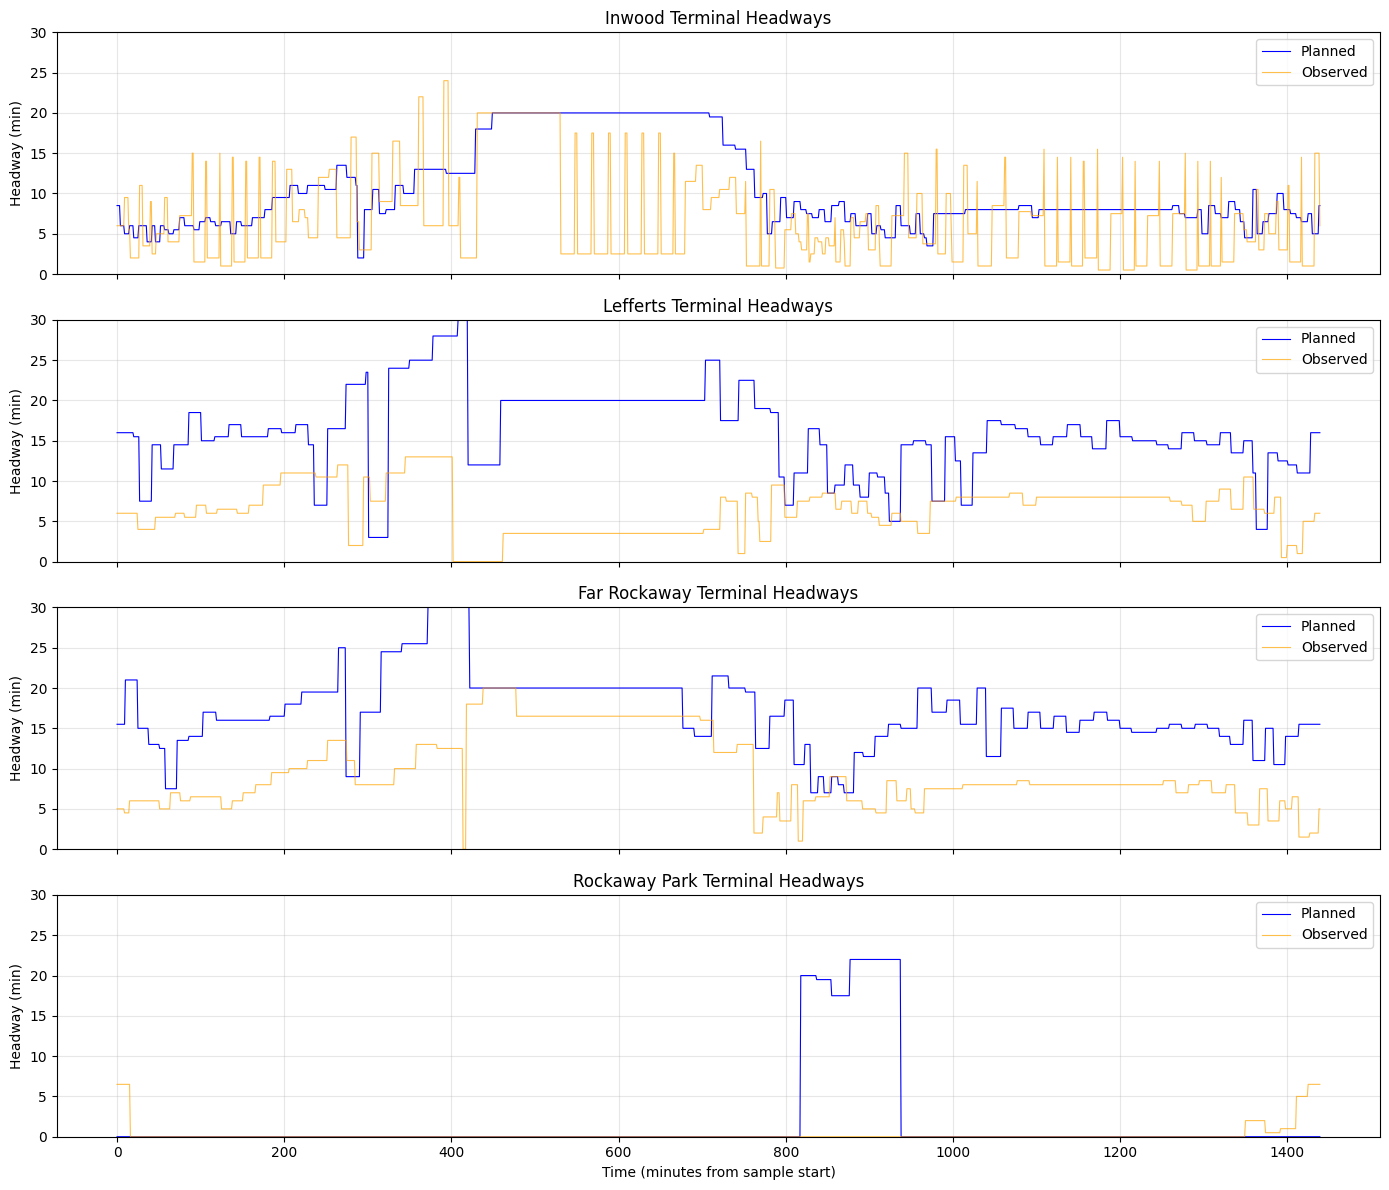

Saved visualization to ../images/terminal_headways_planned_vs_observed.png


In [9]:
# 8. Visualization: Compare Planned vs Observed

# Load observed for comparison
try:
    observed = np.load('../data/schedule_matrix_4terminal.npy')
    has_observed = True
except:
    has_observed = False

terminal_names = ['Inwood', 'Lefferts', 'Far Rockaway', 'Rockaway Park']

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Sample 24 hours
t_start = 50000
t_len = 1440  # 24 hours

for idx, (ax, name) in enumerate(zip(axes, terminal_names)):
    planned = schedule_matrix[t_start:t_start+t_len, idx, 0]
    ax.plot(planned, linewidth=0.8, label='Planned', color='blue')
    
    if has_observed:
        obs = observed[t_start:t_start+t_len, idx, 0]
        ax.plot(obs, linewidth=0.8, label='Observed', color='orange', alpha=0.7)
    
    ax.set_ylabel('Headway (min)')
    ax.set_title(f'{name} Terminal Headways')
    ax.set_ylim(0, 30)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (minutes from sample start)')
plt.tight_layout()
plt.savefig('../images/terminal_headways_planned_vs_observed.png', dpi=150)
plt.show()

print("Saved visualization to ../images/terminal_headways_planned_vs_observed.png")

In [10]:
# 9. Summary Statistics Comparison

print("="*60)
print("PLANNED vs OBSERVED SCHEDULE COMPARISON")
print("="*60)

for idx, name in enumerate(terminal_names):
    planned = schedule_matrix[:, idx, 0]
    planned_nonzero = planned[planned > 0]
    
    print(f"\n{name}:")
    print(f"  PLANNED:")
    print(f"    Zero fraction: {(planned == 0).sum() / len(planned):.1%}")
    if len(planned_nonzero) > 0:
        print(f"    Mean headway: {planned_nonzero.mean():.2f} min")
        print(f"    Std headway: {planned_nonzero.std():.2f} min")
    
    if has_observed:
        obs = observed[:, idx, 0]
        obs_nonzero = obs[obs > 0]
        print(f"  OBSERVED:")
        print(f"    Zero fraction: {(obs == 0).sum() / len(obs):.1%}")
        if len(obs_nonzero) > 0:
            print(f"    Mean headway: {obs_nonzero.mean():.2f} min")
            print(f"    Std headway: {obs_nonzero.std():.2f} min")

PLANNED vs OBSERVED SCHEDULE COMPARISON

Inwood:
  PLANNED:
    Zero fraction: 0.0%
    Mean headway: 11.24 min
    Std headway: 5.09 min
  OBSERVED:
    Zero fraction: 0.0%
    Mean headway: 7.36 min
    Std headway: 5.73 min

Lefferts:
  PLANNED:
    Zero fraction: 0.0%
    Mean headway: 17.33 min
    Std headway: 5.10 min
  OBSERVED:
    Zero fraction: 4.3%
    Mean headway: 8.17 min
    Std headway: 4.73 min

Far Rockaway:
  PLANNED:
    Zero fraction: 0.1%
    Mean headway: 18.07 min
    Std headway: 4.44 min
  OBSERVED:
    Zero fraction: 0.3%
    Mean headway: 9.53 min
    Std headway: 4.40 min

Rockaway Park:
  PLANNED:
    Zero fraction: 93.6%
    Mean headway: 20.60 min
    Std headway: 1.71 min
  OBSERVED:
    Zero fraction: 94.7%
    Mean headway: 3.28 min
    Std headway: 2.46 min
